# House Price Prediction Using PyTorch

This notebook builds a neural network using PyTorch to predict house prices. It closely follows a Keras/TensorFlow version but is implemented in PyTorch. The dataset is split into 80% training and 20% validation (from `train.csv`), and a final prediction is made on `test.csv` with the results saved as `predictions.csv`.

### How Many Nodes Should You Put?

There is no fixed rule for determining the exact number of nodes in each hidden layer. A common strategy is to start with a reasonably large number and then gradually reduce it in subsequent layers. In this example, we use **128 nodes in the first hidden layer** and **64 nodes in the second layer** as a baseline. These values are chosen based on the dataset size and complexity. You should perform hyperparameter tuning (e.g., using cross-validation) to explore if a different architecture (more or fewer nodes/layers) improves performance.

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## 1. Load the Data

Replace the placeholder paths with the actual file paths for `train.csv` and `test.csv`.

In [2]:
# Replace these paths with the actual file paths
train_path = 'train.csv'
test_path = 'test.csv'

# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


## 2. Data Preprocessing

### 2.1 Missing Values and Encoding

We fill missing values in numeric columns with the median and in categorical columns with the mode. Then, categorical features are converted into dummy (one-hot) variables. In the training data, we drop the `Id` column and separate the target variable `SalePrice`.

In [3]:
def fill_missing_values(df):
    # Fill numeric columns with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop the Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Separate target variable and features
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

Processed training features shape: (1000, 230)


/tmp/ipykernel_6426/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_6426/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

### 2.2 Train-Validation Split and Scaling

We split the training data into 80% training and 20% validation sets, and then scale the features using `StandardScaler`.

In [4]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 230)
X_val_scaled shape: (200, 230)


## 3. Convert Data to PyTorch Tensors

We now convert our numpy arrays into PyTorch tensors for training.

In [5]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

print('X_train_tensor shape:', X_train_tensor.shape)
print('X_val_tensor shape:', X_val_tensor.shape)

X_train_tensor shape: torch.Size([800, 230])
X_val_tensor shape: torch.Size([200, 230])


## 4. Define the PyTorch Neural Network Model

We create a simple feed-forward neural network with two hidden layers. The first hidden layer has 128 nodes and the second has 64 nodes. As noted earlier, these choices are a starting point—you may experiment with other sizes.

In [6]:
class HousePriceNet(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = HousePriceNet(input_dim).to(device)
print(model)

HousePriceNet(
  (model): Sequential(
    (0): Linear(in_features=230, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 5. Train the Model

We use the Mean Squared Error (MSE) loss and the Adam optimizer. The training loop runs for 100 epochs, during which we record the training and validation loss.

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [10/100], Train Loss: 41067585536.0000, Val Loss: 34067146752.0000
Epoch [20/100], Train Loss: 41066704896.0000, Val Loss: 34066327552.0000
Epoch [30/100], Train Loss: 41064562688.0000, Val Loss: 34064492544.0000
Epoch [40/100], Train Loss: 41060286464.0000, Val Loss: 34060849152.0000
Epoch [50/100], Train Loss: 41052332032.0000, Val Loss: 34054309888.0000
Epoch [60/100], Train Loss: 41039536128.0000, Val Loss: 34043557888.0000
Epoch [70/100], Train Loss: 41019449344.0000, Val Loss: 34027106304.0000
Epoch [80/100], Train Loss: 40990613504.0000, Val Loss: 34003240960.0000
Epoch [90/100], Train Loss: 40950337536.0000, Val Loss: 33970241536.0000
Epoch [100/100], Train Loss: 40896217088.0000, Val Loss: 33926283264.0000


## 6. Evaluate the Model

We predict on the validation set and compute the RMSE.

In [8]:
model.eval()
with torch.no_grad():
    val_preds = model(X_val_tensor).cpu().numpy().flatten()

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print('Validation RMSE:', rmse)

Validation RMSE: 184190.88811339176


## 7. Prepare Test Data and Make Predictions

We process the test data in the same way as the training data. After aligning the columns (after one-hot encoding) and scaling the features, we predict the house prices.

In [9]:
# Fill missing values in test data
test_df = fill_missing_values(test_df.copy())

# Save the test Ids and drop the 'Id' column
test_ids = test_df['Id']
test_df.drop('Id', axis=1, inplace=True)

# Convert categorical features to dummy variables
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataframe to training features (fill missing columns with 0)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Scale test features
test_scaled = scaler.transform(test_df)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

# Predict on test data
model.eval()
with torch.no_grad():
    test_preds = model(test_tensor).cpu().numpy().flatten()

print('Test predictions shape:', test_preds.shape)

Test predictions shape: (460,)


/tmp/ipykernel_6426/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_6426/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 8. Save the Predictions

The predictions are saved to a CSV file with columns **ID** (integer) and **SALEPRICE** (float).

In [10]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'SALEPRICE': test_preds
})

# Save to CSV (replace with your desired output path)
predictions_csv_path = 'predictions_pytorch.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print('Predictions saved to', predictions_csv_path)

Predictions saved to predictions_pytorch.csv


## 9. (Optional) Plot Training and Validation Loss

This plot can help you monitor the training process over epochs.

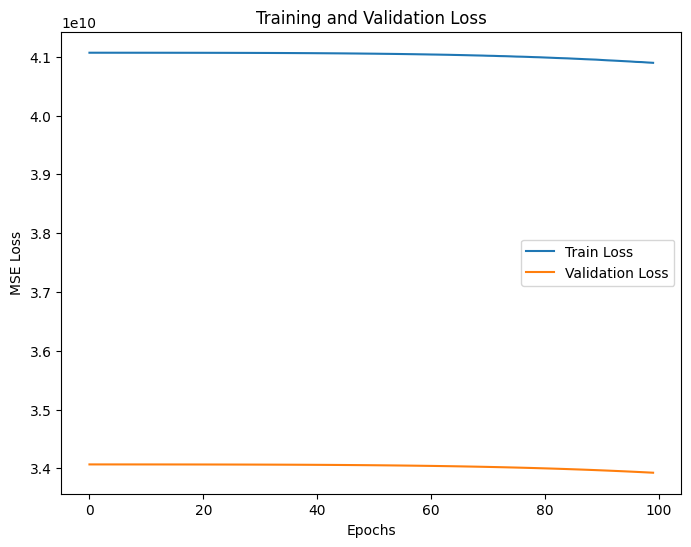

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()